In [1]:
import csv

from sympy import Matrix, eye, ones
from sympy.physics.quantum import TensorProduct

WEIGHTS = {"self_loops": 1, "transitions": 1, "failure_masking": 1}

reader = csv.reader(open("transitions.csv", "r"))
csv_content = list(reader)
components = [component.lstrip() for component in csv_content[0]]
transition_matrix = csv_content[1:]

component_transitions = Matrix(transition_matrix)  # Initial component transition probabilities
num_components = len(transition_matrix)

states = ("operational", "degrading", "unresponsive")
# taken from slides
inner_state_transitions = Matrix([[0.15, 0.05, 0.00],
                                  [0.50, 0.25, 0.10],
                                  [0.25, 0.00, 0.50]])

# create big matrix by adding self-loops
self_loops = TensorProduct(eye(num_components), inner_state_transitions)
# calculate probability of leaving component per row
inverse_self_loop_sums = self_loops * ones(self_loops.shape[1], 1)
inverse_self_loop_sums = inverse_self_loop_sums.applyfunc(lambda a: 1 - a)
# seperate transition matrix
transitions = TensorProduct(component_transitions, eye(len(states)))
# possible back propagation (failure masking)
failure_masking_identity = Matrix([[0, 0, 0], [0, 0, 0], [1, 0, 0]])
transitions_failure_masking = TensorProduct(component_transitions.T, failure_masking_identity)

# "join matrizes and normalize values
full_transitions_without_self_loops = transitions * WEIGHTS["transitions"] + transitions_failure_masking * WEIGHTS[
    "failure_masking"]
full_transitions_without_self_loops_sums = full_transitions_without_self_loops * ones(
    full_transitions_without_self_loops.shape[1], 1)
full_transitions_without_self_loops_sums = full_transitions_without_self_loops_sums.applyfunc(lambda a: a ** -1)

# scale matrix according to "free transition space"
normalizing_vector = inverse_self_loop_sums.multiply_elementwise(full_transitions_without_self_loops_sums)
normalizing_matrix = normalizing_vector * ones(1, full_transitions_without_self_loops.shape[0])

# join all matrizes together
normalized_transition_matrix = full_transitions_without_self_loops.multiply_elementwise(normalizing_matrix)
final_transition_matrix = normalized_transition_matrix + self_loops * WEIGHTS["self_loops"]

final_transition_matrix

Matrix([
[              0.15,   0.05,                  0,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,     0,    0,     0,     0,    0,     0,                  0,    0,     0,                  0,      0,                  0,                  0,     0,                  0,     0,    0,                  0,     0,    0,     0,                  0,      0,                  0,   0.8,      0,                  0,     0,    0,     0,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,                  0,     0,                  0,                  0,    0,                  0],
[               0.5,   0.25,                0.1,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,     0,    0,     0,     0,    0,     0,                  0,    0,     0,                  0,      0,                  0,                  0,     0,                  0,     0,    0,                  0,     0,    0, 

In [23]:
normalized_transition_matrix

Matrix([
[                 0,      0,                  0,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,     0,    0,     0,     0,    0,     0,                  0,    0,     0,                  0,      0,                  0,                  0,     0,                  0,     0,    0,                  0,     0,    0,     0,                  0,      0,                  0,   0.8,      0,                  0,     0,    0,     0,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,                  0,     0,                  0,                  0,    0,                  0],
[                 0,      0,                  0,     0,    0,     0,                  0,     0,                  0,     0,    0,     0,     0,    0,     0,     0,    0,     0,                  0,    0,     0,                  0,      0,                  0,                  0,     0,                  0,     0,    0,                  0,     0,    0, 

In [2]:
from ipywidgets import IntProgress
from sympy import zeros
from IPython.display import display
# random walks starting at random component
import random

trace_len = 30
number_of_traces = 100
raw_traces = []
progress_bar = IntProgress(min=0, max=number_of_traces)
display(progress_bar)

for j in range(number_of_traces):
    # chose a random component from the available ones
    start_component = random.randint(0, 18) * 3
    start_vector = zeros(1, num_components * 3)
    start_vector[start_component] = 1
    trace = [start_component]
    current_vector = start_vector
    for i in range(trace_len - 1):
        next_step_probability_distribution = current_vector * final_transition_matrix
        next_index = random.choices(range(0, len(next_step_probability_distribution)),
                                    weights=next_step_probability_distribution, k=1)[0]
        trace.append(next_index)
        current_vector = zeros(1, num_components * 3)
        current_vector[next_index] = 1

    raw_traces.append(trace)
    progress_bar.value = j

raw_traces

IntProgress(value=0)

[[15,
  12,
  39,
  18,
  54,
  54,
  55,
  54,
  55,
  55,
  54,
  0,
  36,
  27,
  30,
  9,
  3,
  42,
  48,
  48,
  15,
  12,
  39,
  39,
  18,
  19,
  55,
  54,
  6,
  7],
 [6,
  21,
  36,
  27,
  30,
  9,
  3,
  42,
  43,
  44,
  44,
  50,
  50,
  48,
  48,
  15,
  12,
  39,
  39,
  39,
  18,
  19,
  18,
  54,
  24,
  0,
  36,
  27,
  30,
  9],
 [36,
  36,
  27,
  27,
  30,
  9,
  3,
  42,
  48,
  15,
  12,
  12,
  39,
  18,
  54,
  54,
  6,
  0,
  36,
  27,
  27,
  27,
  30,
  9,
  3,
  42,
  48,
  15,
  12,
  39],
 [15,
  12,
  39,
  18,
  54,
  51,
  33,
  34,
  34,
  34,
  33,
  54,
  0,
  36,
  27,
  30,
  9,
  3,
  42,
  43,
  44,
  42,
  48,
  15,
  12,
  12,
  12,
  12,
  39,
  18],
 [12,
  39,
  18,
  19,
  19,
  18,
  54,
  21,
  36,
  36,
  27,
  30,
  9,
  3,
  42,
  42,
  42,
  48,
  48,
  15,
  12,
  12,
  39,
  18,
  54,
  45,
  0,
  36,
  27,
  30],
 [45,
  33,
  54,
  24,
  33,
  54,
  54,
  6,
  0,
  36,
  27,
  30,
  9,
  3,
  42,
  48,
  48,
  15,
  16,
  16,
 

In [3]:
from collections import namedtuple

TraceItem = namedtuple("TraceItem", "component state")
traces = [[TraceItem(components[item // 3], states[item % 3]) for item in raw_trace] for raw_trace in raw_traces]

traces

[[TraceItem(component='Comment Item Filter', state='operational'),
  TraceItem(component='Category Item Filter', state='operational'),
  TraceItem(component='Recommendation Item Filter', state='operational'),
  TraceItem(component='Future Sales Item Filter', state='operational'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Supervisory Component', state='degrading'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Supervisory Component', state='degrading'),
  TraceItem(component='Supervisory Component', state='degrading'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Authentication Service', state='operational'),
  TraceItem(component='Query Service', state='operational'),
  TraceItem(component='Last Second Sales Item Filter', state='operational'),
  TraceItem(component='Past Sales 

In [60]:
# with open("data/traces-30.txt", "w") as textfile:
#     textfile.write(repr(traces))

with open("data/traces-30.txt", "r") as textfile:
    traces = eval(textfile.read())
traces

[[TraceItem(component='User Management Service', state='operational'),
  TraceItem(component='User Management Service', state='operational'),
  TraceItem(component='Persistence Service', state='operational'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Inventory Service', state='operational'),
  TraceItem(component='Persistence Service', state='operational'),
  TraceItem(component='Supervisory Component', state='operational'),
  TraceItem(component='Inventory Service', state='operational'),
  TraceItem(component='Inventory Service', state='operational'),
  TraceItem(component='Query Service', state='operational'),
  TraceItem(component='Last Second Sales Item Filter', state='operational'),
  TraceItem(component='Last Second Sales Item Filter', state='operational'),
  TraceItem(component='Last Second Sales Item Filter', state='operational'),
  TraceItem(component='Past Sales Item Filter', state='operational'),
  TraceItem(component='Buy No

In [31]:
def check_normal_operation(inner_trace: list) -> bool:
    return all(item.state == "operational" for item in inner_trace)


def check_failure_masking(inner_trace: list) -> bool:
    for (index, value) in enumerate(inner_trace):
        if value.state == "unresponsive" and index <= len(inner_trace) - 3:
            if inner_trace[index + 1].component != value.component and inner_trace[index + 1].state == "unresponsive":
                if inner_trace[index + 2].component == value.component and inner_trace[
                    index + 2].state == "operational":
                    return True
    return False


def check_systemic_degradation(inner_trace: list) -> bool:
    for (index, value) in enumerate(inner_trace):
        if value.state == "degrading" and index < len(inner_trace) - 1:
            if inner_trace[index + 1].component != value.component and inner_trace[index + 1].state == "degrading":
                return True
    return False


def check_failure_cascade(inner_trace: list) -> bool:
    for (index, value) in enumerate(inner_trace):
        if value.state == "degrading" and index <= len(inner_trace) - 3:
            if inner_trace[index + 1].component == value.component and inner_trace[index + 1].state == "unresponsive":
                if inner_trace[index + 2].component != value.component and inner_trace[index + 2].state == "degrading":
                    return True
            if inner_trace[index + 1].component != value.component and inner_trace[index + 1].state == "degrading":
                if inner_trace[index + 2].component == inner_trace[index + 1].component and inner_trace[
                    index + 2].state == "unresponsive":
                    return True
    return False


def check_intermittent_failure(inner_trace: list) -> bool:
    for (index, value) in enumerate(inner_trace):
        if value.state == "degrading" and index < len(inner_trace) - 1:
            if inner_trace[index + 1].component == value.component and inner_trace[index + 1].state == "operational":
                return True
    return False


# failure_mask_injection = deque([TraceItem(component='Bid and Buy Service', state='operational'), TraceItem(component='Supervisory Component', state='operational'), TraceItem(component='Authentication Service', state='operational'), TraceItem(component='Item Management Service', state='operational'), TraceItem(component='Item Management Service', state='degrading'), TraceItem(component='Item Management Service', state='unresponsive'), TraceItem(component='Item Management Service', state='unresponsive'), TraceItem(component='Item Management Service', state='unresponsive'), TraceItem(component='Authentication Service', state='unresponsive'), TraceItem(component='Item Management Service', state='operational')])
# traces.append(failure_mask_injection)

traces_operational = [check_normal_operation(inner_trace) for inner_trace in traces]
traces_failure_masked = [check_failure_masking(inner_trace) for inner_trace in traces]
traces_systemic_degradation = [check_systemic_degradation(inner_trace) for inner_trace in traces]
traces_failure_cascade = [check_failure_cascade(inner_trace) for inner_trace in traces]
traces_intermittent_failure = [check_intermittent_failure(inner_trace) for inner_trace in traces]
print("Fully Operational Traces", traces_operational.count(True))
print("Failure Masked Traces", traces_failure_masked.count(True))
print("Systemic Degradation Traces", traces_systemic_degradation.count(True))
print("Failure Cascade Traces", traces_failure_cascade.count(True))
print("Intermittent Failure Traces", traces_intermittent_failure.count(True))

# for i, b in ((i, a) for i, a in enumerate(traces) if any(item.state == "unresponsive" for item in a)):
#     print(i, [value.state for value in b])


Fully Operational Traces 6348
Failure Masked Traces 3
Systemic Degradation Traces 707
Failure Cascade Traces 70
Intermittent Failure Traces 2562


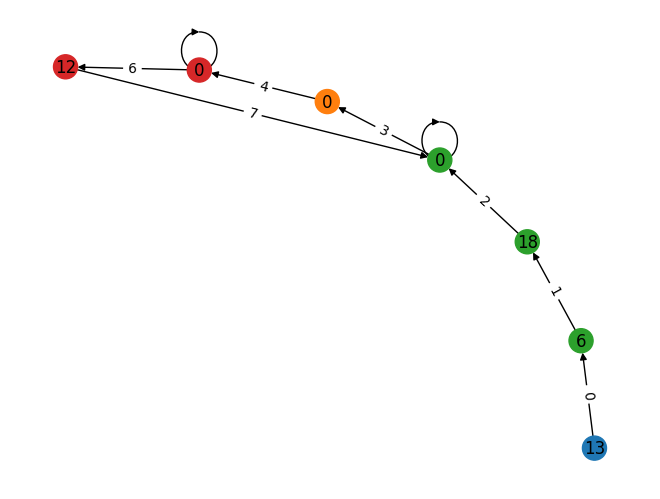

In [32]:
import networkx
import matplotlib.pyplot


def visualize_trace(inner_trace: list):
    graph = networkx.DiGraph()
    graph.add_nodes_from(inner_trace)
    pos = networkx.spiral_layout(graph, equidistant=True)
    labels = {node: components.index(node.component) for node in inner_trace}
    state_color = {"operational": "tab:green", "degrading": "tab:orange", "unresponsive": "tab:red"}
    colors = [state_color[node.state] for node in graph]
    colors[0] = "tab:blue"
    for index, item in enumerate(inner_trace):
        if index < len(inner_trace) - 1:
            graph.add_edge(item, inner_trace[index + 1], label=index)

    networkx.draw(graph, pos, node_color=colors)
    networkx.draw_networkx_labels(graph, pos, labels=labels)
    networkx.draw_networkx_edge_labels(graph, pos,
                                       edge_labels={edge: graph.get_edge_data(*edge)["label"] for edge in graph.edges})
    matplotlib.pyplot.show()


failure_masking = [inner_trace for inner_trace in traces if check_failure_masking(inner_trace)]
visualize_trace(failure_masking[0])

289 11 0.03806228373702422


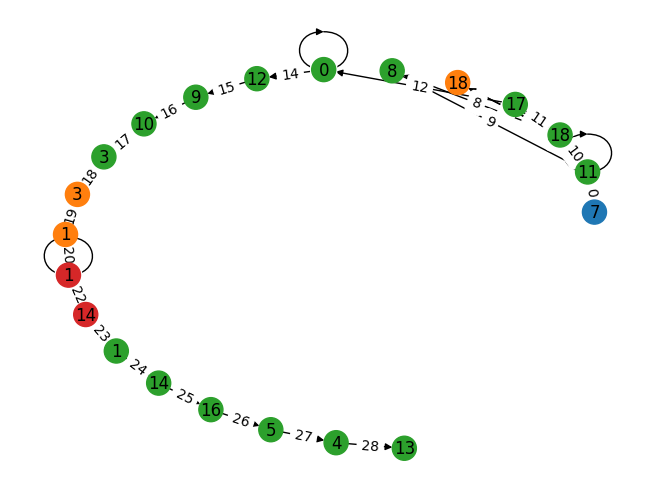

In [61]:
analysing_traces = [inner_trace for inner_trace in traces if check_failure_cascade(inner_trace)]
intermittent_then_cascade = [inner_trace for inner_trace in analysing_traces if check_failure_masking(inner_trace)]
len(intermittent_then_cascade)
print(len(analysing_traces), len(intermittent_then_cascade), len(intermittent_then_cascade) / len(analysing_traces))

visualize_trace(intermittent_then_cascade[0])

In [64]:
transition_eigenvectors = final_transition_matrix.eigenvects()

In [73]:
transition_eigenvals = final_transition_matrix.eigenvals()

In [75]:
transition_eigenvectors_real = final_transition_matrix.evalf().eigenvects()

In [77]:
transition_eigenvectors_real

KeyboardInterrupt: 